In [1]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

from matplotlib.font_manager import FontProperties
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering
from sklearn import manifold
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from abc import ABCMeta, abstractmethod

%matplotlib inline
plt.rcParams['axes.unicode_minus']=False
engine = create_engine('sqlite:///fund.db')

# 抓出12月的資料以分群

In [2]:
month_data = pd.read_sql(sql='select * from price where date between "2017-12-01" and "2017-12-31" order by date asc', con=engine,index_col='date')

In [3]:
month_data

,id,NAV
date,,
2017-12-01,0050 元大台灣50,82.6000
2017-12-01,0051 元大中型100,31.4600
2017-12-01,0052 富邦科技,53.4700
2017-12-01,0053 元大電子,36.1300
2017-12-01,0054 元大台商50,23.9400
2017-12-01,0055 元大MSCI金融,16.2600
2017-12-01,0056 元大高股息,24.8700
2017-12-01,0057 富邦摩台,49.7600
2017-12-01,0058 富邦發達,46.2100


# 從所有基金裡隨機選出300檔做為基金池

In [4]:
random_names = month_data['id'].sample(n=300).values

In [5]:
random_names

array(['ALZDY 聯博日本價值S1.j', 'T2643D 中信全球短高債B$', '00666R 富邦恒生國企反1',
       'UBA13 瑞聯歐洲股eurIC', 'T2776Y 宏利全球動力股票', 'T4804J 合庫全球高收債C$',
       'UBA14 瑞聯歐洲股usdAHC', 'FTZI1 富達美高收益AM.$', 'PIZJ7 鋒裕美高息U2',
       'GSFG0 天達新興多重C2$d', 'PIZN3 鋒裕環高收TXD', 'FPZ03 法盛新歐R/A.$',
       'ALZQ3 聯博全球複I歐元', 'T2117E 柏瑞新市企業債N', 'PIZC2 鋒裕新市貨債A2',
       'ALZKV 聯博全高債IT$', 'T4506Y 富蘭天然資源組合', 'ALZCV 聯博亞股AD.AudH',
       'T05A7D 元亞太優高息100$', '00690 兆豐藍籌30', 'T3626F 安聯四季豐債組A$',
       'ALZCR 聯博新興價值S1$', 'ALZX5 聯博日本價值I.$', 'T4809B 合庫多元息組合B',
       'ALZHA 聯博新多元I$', 'FLZ89 富蘭坦潛力歐$B.a', 'MFZE1 MFS全資配A2-USD',
       'FPZ13 法盛新歐R/A.e', 'T0458F 匯豐中國多息平B$', 'PTZ11 百達美股精Re',
       'T3203Y 野村成長', 'DWS53 DWS黃金$LC', 'T3744Y 國泰紐幣2021保本',
       'SGF0002 先機美元AdZAhF', 'T2124L 柏瑞特股息收 N$', 'CTYK0 美盛全球固定A$d',
       'ALZJK 聯博美成ADAUDH', 'T0581A 元大中華價值指 $', 'MGF08 宏利美洲增長AA',
       'DWS51 DWSN新高股息LC', 'ALZCN 聯博新興價值I$', 'FLZ79 富蘭坦印度$-Bacc',
       'T3246Y 野村大俄羅斯', 'T2252A 復華全球大趨勢 $', 'T2278Y 復華東協世紀',
       'NBZ21 NB高收債I$a', 'ALZS3 聯博

# 拿出12月所有有淨值的日子

In [6]:
month_date = pd.read_sql(sql='select distinct date from price where date between "2017-12-01" and "2017-12-31" order by date asc', con=engine,index_col='date').index

In [7]:
month_date

Index(['2017-12-01', '2017-12-04', '2017-12-05', '2017-12-06', '2017-12-07',
       '2017-12-08', '2017-12-11', '2017-12-12', '2017-12-13', '2017-12-14',
       '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20', '2017-12-21',
       '2017-12-22', '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28',
       '2017-12-29'],
      dtype='object', name='date')

In [8]:
month_date_len = len(month_date)

# 拿出基金池裡的所有基金的12月淨值

In [9]:
month_NAV = np.zeros((300,month_date_len))

In [10]:
month_NAV

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
for j in range (300):
    temp = month_data[month_data['id'] == random_names[j]]
    month_NAV[j][0] = temp.iloc[0]['NAV']
    for i,day in enumerate(month_date[1:]):
        try:
            month_NAV[j][i+1] = temp.loc[day]['NAV']
        except:
            month_NAV[j][i+1] = month_NAV[j][i]

In [12]:
for i in month_NAV[:50]:
    print (i)

[37.66 37.66 37.48 37.41 37.44 37.71 37.69 38.04 38.02 37.8  37.81 38.
 37.81 37.59 37.64 37.59 37.59 37.59 37.59 37.59 37.59]
[9.3305 9.3551 9.3319 9.3086 9.2929 9.3192 9.3566 9.3138 9.3272 9.2991
 9.2584 9.2681 9.285  9.2403 9.2595 9.2544 9.2544 9.2544 9.2115 9.2096
 9.2194]
[71.92 71.92 71.91 71.54 71.46 71.69 71.92 72.12 72.2  72.28 71.74 72.32
 72.57 72.34 72.28 72.55 72.55 72.55 72.55 72.55 72.55]
[12.38 12.48 12.3  11.87 11.82 11.89 12.08 11.97 12.02 12.19 12.08 12.13
 12.03 12.18 12.15 12.24 12.22 11.97 12.1  12.3  12.46]
[33.78 33.9  33.56 33.01 33.2  33.83 34.37 33.97 34.33 34.17 33.79 33.9
 34.13 34.07 34.4  34.62 34.62 34.62 34.18 34.39 34.57]
[16.48 16.31 16.22 16.17 16.21 16.42 16.49 16.51 16.59 16.4  16.54 16.52
 16.48 16.49 16.49 16.45 16.45 16.47 16.51 16.46 16.37]
[16.9172 16.9172 16.8051 16.6207 16.1489 16.2101 16.3748 16.6362 16.5183
 16.3274 16.134  16.0151 16.2499 16.3985 16.7052 16.7052 16.7052 16.7052
 16.7052 16.7052 16.7052]
[15.0457 15.0461 15.0462 15.0463 15

# 計算基金池裡的所有基金的12月漲跌幅

In [13]:
month_rate = np.zeros((300,month_date_len-1))

In [14]:
month_rate

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
for j in range (300):
    for i in range (month_date_len-1):
        month_rate[j][i] = (month_NAV[j][i+1] - month_NAV[j][i]) / month_NAV[j][i]

In [16]:
for i in month_rate[:50]:
    print (i)

[ 0.         -0.00477961 -0.00186766  0.00080192  0.00721154 -0.00053036
  0.00928628 -0.00052576 -0.00578643  0.00026455  0.00502513 -0.005
 -0.00581857  0.00133014 -0.00132837  0.          0.          0.
  0.          0.        ]
[ 0.00263651 -0.00247993 -0.00249681 -0.00168661  0.00283012  0.00401322
 -0.00457431  0.00143873 -0.00301269 -0.00437677  0.0010477   0.00182346
 -0.00481422  0.00207785 -0.00055079  0.          0.         -0.00463563
 -0.00020626  0.00106411]
[ 0.         -0.00013904 -0.00514532 -0.00111826  0.00321858  0.00320826
  0.00278087  0.00110926  0.00110803 -0.00747095  0.00808475  0.00345686
 -0.00316935 -0.00082942  0.00373547  0.          0.          0.
  0.          0.        ]
[ 0.00807754 -0.01442308 -0.03495935 -0.0042123   0.00592217  0.01597981
 -0.00910596  0.00417711  0.01414309 -0.00902379  0.00413907 -0.00824402
  0.01246883 -0.00246305  0.00740741 -0.00163399 -0.02045827  0.01086048
  0.01652893  0.01300813]
[ 0.0035524  -0.0100295  -0.01638856  0.0

# 使用K-Means進行分群，並用MDS壓成2維座標，圖形化呈現

In [17]:
kmeans = KMeans(n_clusters=4, n_jobs=8).fit(month_rate)

In [18]:
mds = MDS(n_components=2, dissimilarity='euclidean', n_jobs=8).fit(month_rate).embedding_

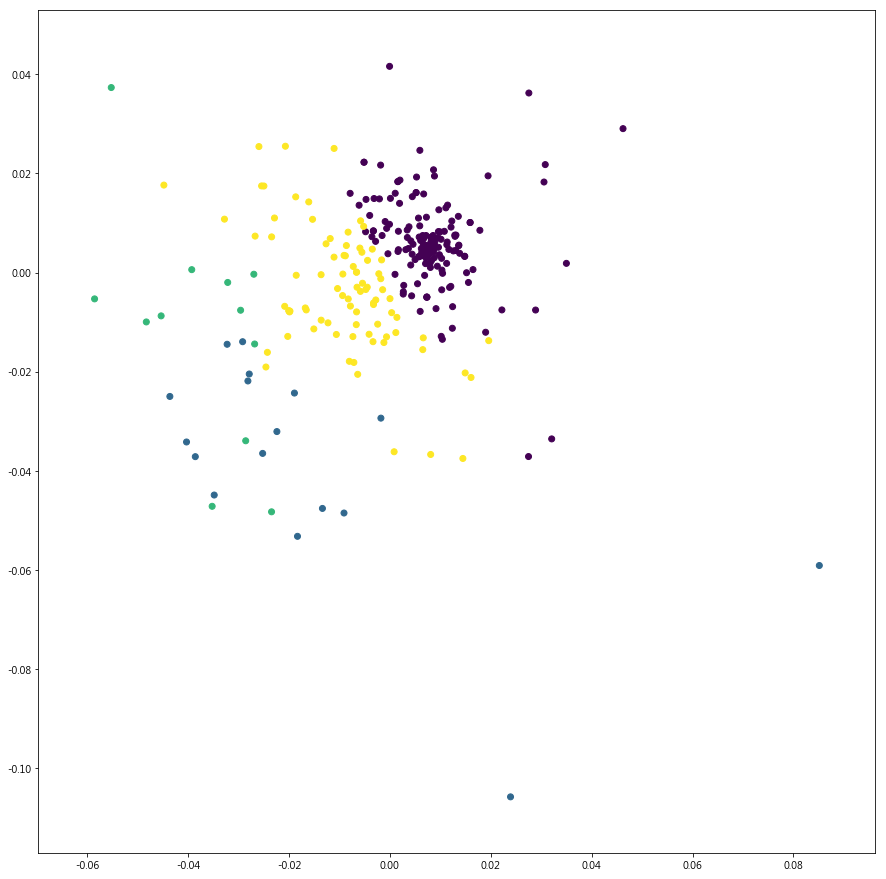

In [19]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(bottom=0.1)
plt.scatter(mds[:, 0], mds[:, 1], c=kmeans.labels_)

#for label, x, y in zip(random_names, mds[:, 0], mds[:, 1]):
#    plt.annotate(
#        label,
#        xy=(x, y), xytext=(-3, 3),
#        textcoords='offset points', ha='right', va='bottom')
plt.show()

# 使用hierarchical進行分群，並用MDS壓成2維座標，圖形化呈現

In [20]:
hierarchical = AgglomerativeClustering(n_clusters=4).fit(month_rate)

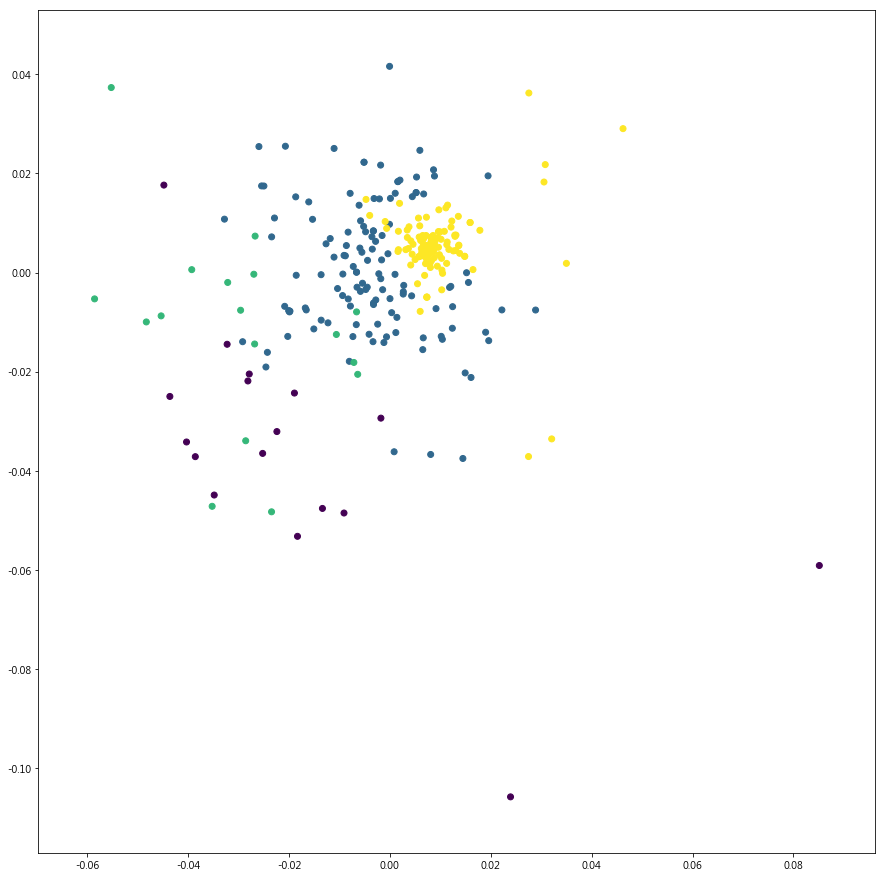

In [21]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(bottom=0.1)
plt.scatter(mds[:, 0], mds[:, 1], c=hierarchical.labels_)

#for label, x, y in zip(random_names, mds[:, 0], mds[:, 1]):
#    plt.annotate(
#        label,
#        xy=(x, y), xytext=(-3, 3),
#        textcoords='offset points', ha='right', va='bottom')
plt.show()

# 開始進行收益率回測，對比對象為台灣50，時間範圍為2017年

In [22]:
data = pd.read_sql(sql='select * from price where date between "2017-01-01" and "2017-12-31" order by date asc', con=engine,index_col='date')

In [23]:
data

,id,NAV
date,,
2017-01-03,0050 元大台灣50,72.0300
2017-01-03,0051 元大中型100,25.6800
2017-01-03,0052 富邦科技,43.4000
2017-01-03,0053 元大電子,29.8400
2017-01-03,0054 元大台商50,21.3400
2017-01-03,0055 元大MSCI金融,14.5000
2017-01-03,0056 元大高股息,23.1800
2017-01-03,0057 富邦摩台,42.2800
2017-01-03,0058 富邦發達,40.2900


# 從四個分群裡隨機選出4檔基金(K-Means)

In [24]:
camp = pd.DataFrame(data=kmeans.labels_, index=random_names,columns=['label'])

In [25]:
camp

,label
FTZ67 富達全球健康護理,0
T1656F 群益中國金采BC,0
ISZC1 景順環球股A$,3
00685L 群益臺灣加權正2,2
T1108Y 摩根龍揚,1
T3237Y 野村全球生技醫療,0
PYZT0 施羅德能源Ca$,3
T1107Y 摩根第一貨幣市場,0
FTZR2 富達歐公司債Aaeu,0
ALZLQ 聯博聚焦美國S$,0


In [26]:
choose_name = []
for i in range(4):
    choose_name.append(camp[camp['label'] == i].sample(n=1).index[0])

In [27]:
choose_name.append('0050 元大台灣50')

In [28]:
choose_name

['00717 富邦美特別股 ETF',
 'T0334A 第一金中國世紀 C',
 'T3328A 聯邦太平洋平衡A',
 'GSFG3 天達新興多重A$ac',
 '0050 元大台灣50']

# 找出2017年所有有淨值的日子

In [29]:
year_date = pd.read_sql(sql='select distinct date from price where date between "2017-01-01" and "2017-12-31" order by date asc', con=engine,index_col='date').index

In [30]:
year_date

Index(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06', '2017-01-09',
       '2017-01-10', '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-16',
       ...
       '2017-12-18', '2017-12-19', '2017-12-20', '2017-12-21', '2017-12-22',
       '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29'],
      dtype='object', name='date', length=246)

In [31]:
year_date_len = len(year_date)

# 拿出四檔基金與台灣50，於2017年的所有淨值

In [32]:
year_NAV = np.zeros((5,year_date_len))

In [33]:
year_NAV

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
for j in range (5):
    temp = data[data['id'] == choose_name[j]]
    year_NAV[j][0] = temp.iloc[0]['NAV']
    for i,day in enumerate(year_date[1:]):
        try:
            year_NAV[j][i+1] = temp.loc[day]['NAV']
        except:
            year_NAV[j][i+1] = year_NAV[j][i]

In [35]:
for i in year_NAV:
    print (i)

[20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.
 20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.
 20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.
 20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.
 20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.
 20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.
 20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.
 20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.
 20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.
 20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.
 20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.
 20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.
 20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.
 20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.   20.
 20.  

# 計算四檔基金與台灣50，於2017年的漲跌幅

In [36]:
year_rate = np.zeros((5,year_date_len-1))

In [37]:
year_rate

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [38]:
for j in range (5):
    for i in range (year_date_len-1):
        year_rate[j][i] = (year_NAV[j][i+1] - year_NAV[j][i]) / year_NAV[j][i]

In [39]:
for i in year_rate:
    print (i)

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         

# 計算四檔基金的合計漲跌幅，並圖像化

In [40]:
choose_rate = []
for i in range(year_date_len-1):
    temp = (year_rate[0][i] + year_rate[1][i] + year_rate[2][i] + year_rate[3][i])/4
    choose_rate.append(temp)

In [41]:
choose_rate

[0.0015368853728841933,
 -0.0007816524083369973,
 -0.0017023776044907562,
 0.0011506291995350719,
 0.0009596444876718075,
 0.00010993417688012774,
 -0.000830468168851855,
 -0.001758693186466079,
 -0.004398372455848845,
 0.002319134026456794,
 0.0016355440748180958,
 -0.0013198931770710208,
 0.002179942009888413,
 0.00034528225759858843,
 0.00032954828299075955,
 0.0014408974276469,
 0.0036169963234767193,
 0.003389559558493542,
 -0.0008250881561847111,
 0.0029115127143860024,
 0.0023995140049984723,
 0.0004719040465205411,
 0.0030263226791673306,
 -0.000851877476613429,
 -0.0017682797822111975,
 0.001468397982053316,
 -0.0019665275001666733,
 0.0,
 0.0032569014809763026,
 0.0010648181715223843,
 0.0020847131975021797,
 0.0019446480229444144,
 -0.0009132602725115355,
 0.0023986400596258052,
 -0.004560250896387289,
 0.0011963596822421206,
 0.002387665502852089,
 0.001797598073940184,
 -0.00176420400421733,
 -0.00489492208582841,
 0.0014836133790499554,
 0.006738293464330948,
 -0.00159791

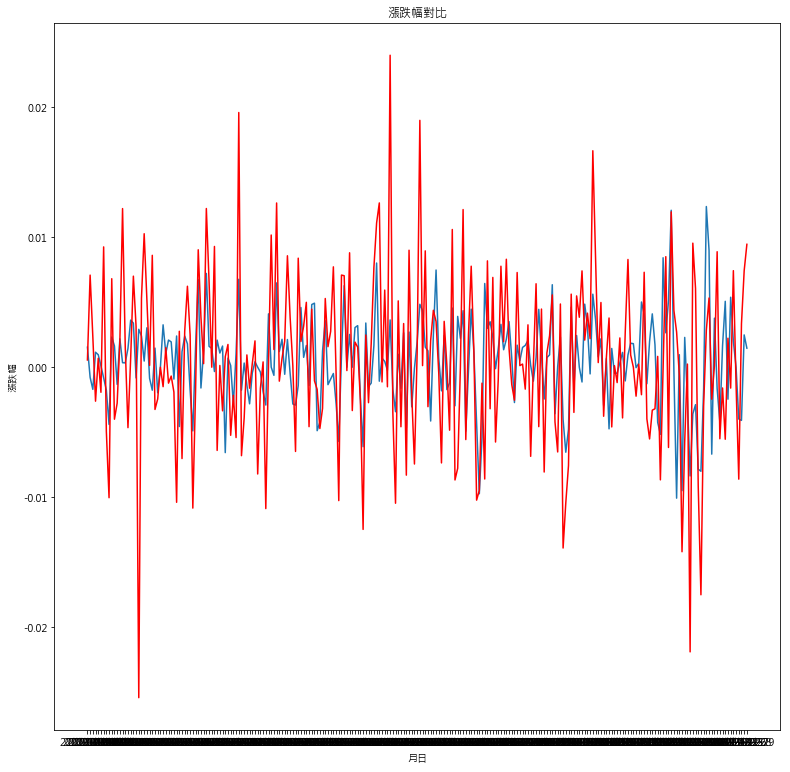

In [42]:
plt.figure(figsize=(13, 13))
plt.xlabel('月日')
plt.ylabel('漲跌幅')
plt.title('漲跌幅對比')
plt.plot(year_date[1:], choose_rate, label='四檔基金')
plt.plot(year_date[1:],year_rate[-1], color='r', label='台灣50')
plt.show()

# 計算四檔基金與台灣50，自2017年初至年尾的收益率，並圖像化

In [43]:
choose_profit = []
compare__profit = []
start = (year_NAV[0][0] + year_NAV[1][0] + year_NAV[2][0] + year_NAV[3][0])/4
for i in range(year_date_len):
    temp = (year_NAV[0][i] + year_NAV[1][i] + year_NAV[2][i] + year_NAV[3][i])/4
    temp = (temp-start)/start*100
    choose_profit.append(temp)
    compare__profit.append((year_NAV[4][i]-year_NAV[4][0])/year_NAV[4][0]*100)

In [44]:
choose_profit

[0.0,
 0.16689668453316944,
 0.16689668453316944,
 0.0259973681676634,
 0.122283916936804,
 0.23237153769617822,
 0.26719517283435373,
 0.2514683698687305,
 0.11682767917322089,
 -0.29351349616458017,
 -0.04926661745354665,
 0.0962865487691292,
 -0.04477324517765266,
 0.16448952081394094,
 0.22531052411977986,
 0.3073145681548252,
 0.4942709503482361,
 0.8452354206117375,
 1.1366627082196636,
 1.0293032063420697,
 1.2883140225310488,
 1.5373752286805393,
 1.5996405302179175,
 1.8905863850820164,
 1.8334563661456582,
 1.7108514940462796,
 1.8496646018551202,
 1.6389575376319985,
 1.6389575376319985,
 1.9396925249542645,
 2.0563597265461984,
 2.26241294091215,
 2.4503321885932614,
 2.384375902686402,
 2.586256699939023,
 2.0324485669351886,
 2.163237795679942,
 2.365920980838976,
 2.5379529479731655,
 2.3550085053117984,
 1.8536765413871639,
 2.017845107038553,
 2.653978239239984,
 2.4935006579580756,
 2.690888082934826,
 3.4099881246589683,
 3.562602304458054,
 3.738325255961747,
 3.665

In [45]:
compare__profit

[0.0,
 0.05553241704844099,
 0.7635707344162115,
 0.9995835068721349,
 0.7358045258919911,
 0.8052200472025521,
 0.6108565875329692,
 1.541024573094543,
 1.0412328196584755,
 0.027766208524220494,
 0.7080383173677705,
 0.3054282937664846,
 0.027766208524220494,
 0.2221296681938034,
 1.4438428432597417,
 1.5965569901430037,
 1.1245314452311568,
 1.193946966541718,
 1.9019852839094884,
 2.2212966819380733,
 -0.37484381507704573,
 0.1527141468832423,
 1.1800638622795978,
 1.7076218242399057,
 1.7215049285020059,
 2.596140497015139,
 2.262945994724414,
 2.0130501180063898,
 2.0130501180063898,
 1.860335971123148,
 2.0130501180063898,
 1.8881021796473683,
 1.8186866583368073,
 1.6243231986672244,
 0.5692072747466286,
 0.8468693599888928,
 0.1388310426211222,
 0.41649312786338627,
 1.0412328196584755,
 1.2911286963764996,
 0.1943634596695829,
 0.0,
 0.9024017770373535,
 1.2911286963764996,
 1.3188949049007397,
 2.554491184228798,
 3.2347632930723282,
 3.2347632930723282,
 4.192697487158123,


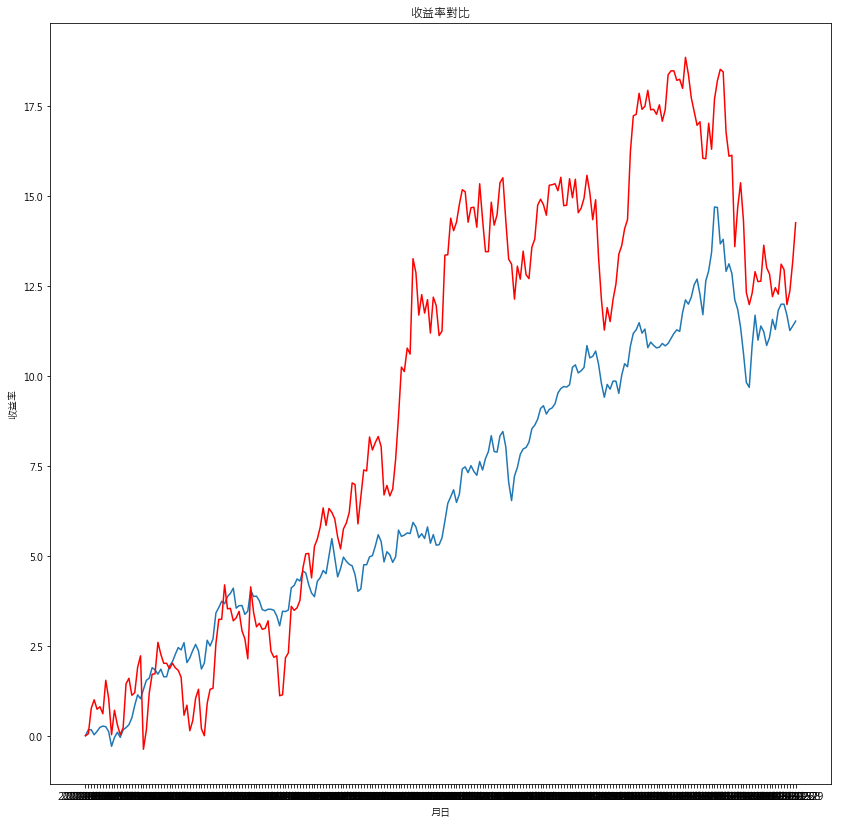

In [46]:
plt.figure(figsize=(14, 14))
plt.xlabel('月日')
plt.ylabel('收益率')
plt.title('收益率對比')
plt.plot(year_date, choose_profit, label='四檔基金')
plt.plot(year_date, compare__profit, color = 'r', label='台灣50')
plt.show()

In [47]:
camp = pd.DataFrame(data=hierarchical.labels_, index=random_names,columns=['label'])

In [48]:
camp

,label
FTZ67 富達全球健康護理,1
T1656F 群益中國金采BC,1
ISZC1 景順環球股A$,1
00685L 群益臺灣加權正2,2
T1108Y 摩根龍揚,0
T3237Y 野村全球生技醫療,1
PYZT0 施羅德能源Ca$,0
T1107Y 摩根第一貨幣市場,3
FTZR2 富達歐公司債Aaeu,3
ALZLQ 聯博聚焦美國S$,1


# 從四個分群裡隨機選出4檔基金(Hierarchical)

In [49]:
choose_name = []
for i in range(4):
    choose_name.append(camp[camp['label'] == i].sample(n=1).index[0])

In [50]:
choose_name.append('0050 元大台灣50')

In [51]:
choose_name

['T1108Y 摩根龍揚',
 'T0816Y 保德信全球醫療生',
 '00685L 群益臺灣加權正2',
 'ALZLA 聯博歐洲收IA$mh',
 '0050 元大台灣50']

# 找出2017年所有有淨值的日子

In [52]:
year_date = pd.read_sql(sql='select distinct date from price where date between "2017-01-01" and "2017-12-31" order by date asc', con=engine,index_col='date').index

In [53]:
year_date

Index(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06', '2017-01-09',
       '2017-01-10', '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-16',
       ...
       '2017-12-18', '2017-12-19', '2017-12-20', '2017-12-21', '2017-12-22',
       '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29'],
      dtype='object', name='date', length=246)

In [54]:
year_date_len = len(year_date)

# 拿出四檔基金與台灣50，於2017年的所有淨值

In [55]:
year_NAV = np.zeros((5,year_date_len))

In [56]:
year_NAV

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [57]:
for j in range (5):
    temp = data[data['id'] == choose_name[j]]
    year_NAV[j][0] = temp.iloc[0]['NAV']
    for i,day in enumerate(year_date[1:]):
        try:
            year_NAV[j][i+1] = temp.loc[day]['NAV']
        except:
            year_NAV[j][i+1] = year_NAV[j][i]

In [58]:
for i in year_NAV:
    print (i)

[24.44 24.53 24.71 24.71 24.83 24.97 25.1  24.9  24.79 24.68 24.77 24.94
 24.9  24.78 24.84 24.9  24.77 24.76 24.89 24.94 25.15 25.19 25.26 25.4
 25.27 25.41 25.48 25.37 25.37 25.52 25.5  25.73 25.68 25.41 25.37 25.39
 25.46 25.51 25.5  25.62 25.54 25.62 25.9  25.96 25.92 26.26 26.22 26.3
 26.27 26.14 26.32 26.41 26.03 26.07 26.14 26.04 25.93 26.26 26.22 26.32
 26.33 26.13 26.2  26.   26.   26.   25.95 25.93 26.18 26.28 26.23 26.53
 26.57 26.66 26.75 26.82 26.82 26.75 26.57 26.72 27.11 27.24 27.29 27.3
 27.4  27.51 27.33 27.26 27.44 27.59 27.65 27.66 27.78 27.75 27.64 27.86
 27.94 27.94 27.97 27.99 28.16 28.65 28.53 28.25 28.39 28.28 28.03 28.19
 28.57 28.57 28.81 28.88 29.02 29.2  29.13 29.02 29.05 28.97 28.89 28.6
 28.92 28.98 28.81 28.89 29.36 29.44 29.65 29.8  29.79 29.9  30.25 30.32
 30.11 30.23 30.22 30.25 30.3  30.18 30.29 30.36 30.36 30.1  30.15 30.51
 30.64 30.58 30.32 29.89 30.26 30.38 30.59 30.64 30.57 30.65 30.96 30.96
 31.17 31.2  31.1  31.15 31.47 31.53 31.61 31.58 31.53 

# 計算四檔基金與台灣50，於2017年的漲跌幅

In [59]:
year_rate = np.zeros((5,year_date_len-1))

In [60]:
year_rate

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [61]:
for j in range (5):
    for i in range (year_date_len-1):
        year_rate[j][i] = (year_NAV[j][i+1] - year_NAV[j][i]) / year_NAV[j][i]

In [62]:
for i in year_rate:
    print (i)

[ 0.00368249  0.00733795  0.          0.00485633  0.00563834  0.00520625
 -0.00796813 -0.00441767 -0.00443727  0.00364668  0.00686314 -0.00160385
 -0.00481928  0.00242131  0.00241546 -0.00522088 -0.00040371  0.0052504
  0.00200884  0.00842021  0.00159046  0.00277888  0.00554236 -0.00511811
  0.00554017  0.00275482 -0.00431711  0.          0.0059125  -0.0007837
  0.00901961 -0.00194326 -0.01051402 -0.00157418  0.00078833  0.00275699
  0.00196386 -0.000392    0.00470588 -0.00312256  0.00313234  0.01092896
  0.0023166  -0.00154083  0.01311728 -0.00152323  0.00305111 -0.00114068
 -0.00494861  0.006886    0.00341945 -0.01438849  0.00153669  0.00268508
 -0.00382555 -0.00422427  0.01272657 -0.00152323  0.00381388  0.00037994
 -0.0075959   0.00267891 -0.00763359  0.          0.         -0.00192308
 -0.00077071  0.00964134  0.00381971 -0.00190259  0.01143729  0.00150773
  0.00338728  0.00337584  0.00261682  0.         -0.00260999 -0.00672897
  0.00564546  0.01459581  0.00479528  0.00183554  0.0

# 計算四檔基金的合計漲跌幅，並圖像化

In [63]:
choose_rate = []
for i in range(year_date_len-1):
    temp = (year_rate[0][i] + year_rate[1][i] + year_rate[2][i] + year_rate[3][i])/4
    choose_rate.append(temp)

In [64]:
choose_rate

[0.006475366363703582,
 0.0015833162449359287,
 0.0008406474569020532,
 0.00455047549980798,
 -0.00048497824746994303,
 -0.0015200411941696094,
 -0.0027464035055879176,
 0.0009164647813213035,
 -0.0011093182734973723,
 -0.002263015193448526,
 0.0020574092341966517,
 -0.002259698369022474,
 -0.0018857862502102284,
 -0.001788829270815475,
 0.00034515483433401954,
 0.0008550534113383914,
 0.0017630345043749313,
 0.0002196226230978791,
 0.0018523665587789422,
 0.003449533466023681,
 0.00165406818875439,
 0.0008607155091212542,
 0.0018042130859578986,
 -0.0006135268930544565,
 0.0032116772204594194,
 0.0018504626297562356,
 -0.000586019068543619,
 0.0,
 0.0014781237682301791,
 0.00021129834752499585,
 0.001030508490298807,
 0.0011630234617196924,
 -0.003037669975679522,
 0.006819568906007058,
 -0.0004555924817582279,
 0.003728201234868948,
 -0.0015688905574365564,
 -0.004485214360943189,
 0.0020473088674640826,
 0.0014473666382658792,
 0.0021248153998129388,
 0.0016951252026048851,
 -0.0001

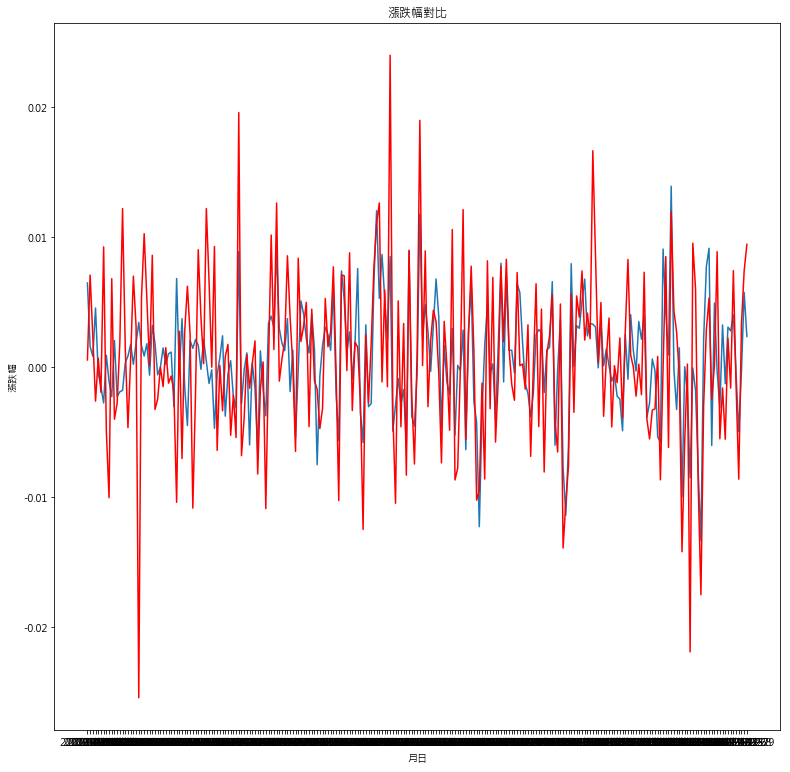

In [65]:
plt.figure(figsize=(13, 13))
plt.xlabel('月日')
plt.ylabel('漲跌幅')
plt.title('漲跌幅對比')
plt.plot(year_date[1:], choose_rate, label='四檔基金')
plt.plot(year_date[1:],year_rate[-1], color='r', label='台灣50')
plt.show()

# 計算四檔基金與台灣50，自2017年初至年尾的收益率，並圖像化

In [66]:
choose_profit = []
compare__profit = []
start = (year_NAV[0][0] + year_NAV[1][0] + year_NAV[2][0] + year_NAV[3][0])/4
for i in range(year_date_len):
    temp = (year_NAV[0][i] + year_NAV[1][i] + year_NAV[2][i] + year_NAV[3][i])/4
    temp = (temp-start)/start*100
    choose_profit.append(temp)
    compare__profit.append((year_NAV[4][i]-year_NAV[4][0])/year_NAV[4][0]*100)

In [67]:
choose_profit

[0.0,
 0.9276909391282298,
 1.1183123649764841,
 1.2708095056551203,
 1.918922353539211,
 1.8045494980302474,
 1.5249714067861264,
 1.1691447452026964,
 1.3343499809378538,
 1.1945609353157933,
 0.8133180836192663,
 1.0928961748633872,
 0.7624857033930542,
 0.5083238022620301,
 0.21603761596136958,
 0.25416190113102405,
 0.5718642775447997,
 0.8260261786758238,
 0.8641504638454783,
 1.1183123649764841,
 1.5758037870123205,
 1.7791333079171505,
 1.9062142584826536,
 2.122251874444041,
 2.0587113991612718,
 2.5162028211970897,
 2.744948532215017,
 2.681408056932283,
 2.681408056932283,
 2.8720294827805195,
 2.922861863006732,
 3.011818528402598,
 3.1897318591943136,
 2.7830728173846713,
 3.8505528021349615,
 3.7997204219087677,
 4.35887660439701,
 4.104714703265985,
 3.418477570212222,
 3.7488880416825734,
 4.041174227983234,
 4.371584699453549,
 4.5749142203583615,
 4.5749142203583615,
 4.841784216545943,
 4.816368026432827,
 4.613038505528034,
 4.562206125301822,
 3.812428516965307,
 3

In [68]:
compare__profit

[0.0,
 0.05553241704844099,
 0.7635707344162115,
 0.9995835068721349,
 0.7358045258919911,
 0.8052200472025521,
 0.6108565875329692,
 1.541024573094543,
 1.0412328196584755,
 0.027766208524220494,
 0.7080383173677705,
 0.3054282937664846,
 0.027766208524220494,
 0.2221296681938034,
 1.4438428432597417,
 1.5965569901430037,
 1.1245314452311568,
 1.193946966541718,
 1.9019852839094884,
 2.2212966819380733,
 -0.37484381507704573,
 0.1527141468832423,
 1.1800638622795978,
 1.7076218242399057,
 1.7215049285020059,
 2.596140497015139,
 2.262945994724414,
 2.0130501180063898,
 2.0130501180063898,
 1.860335971123148,
 2.0130501180063898,
 1.8881021796473683,
 1.8186866583368073,
 1.6243231986672244,
 0.5692072747466286,
 0.8468693599888928,
 0.1388310426211222,
 0.41649312786338627,
 1.0412328196584755,
 1.2911286963764996,
 0.1943634596695829,
 0.0,
 0.9024017770373535,
 1.2911286963764996,
 1.3188949049007397,
 2.554491184228798,
 3.2347632930723282,
 3.2347632930723282,
 4.192697487158123,


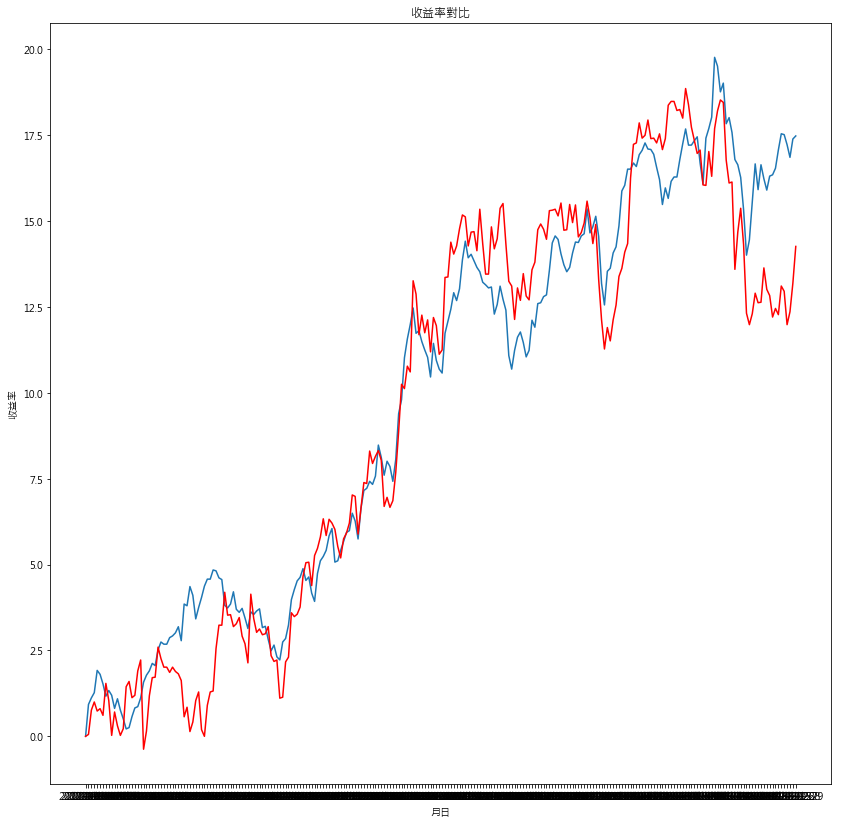

In [69]:
plt.figure(figsize=(14, 14))
plt.xlabel('月日')
plt.ylabel('收益率')
plt.title('收益率對比')
plt.plot(year_date, choose_profit, label='四檔基金')
plt.plot(year_date, compare__profit, color = 'r', label='台灣50')
plt.show()